In [4]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [5]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("serat_kayu\\"):
    sub_folder_files = os.listdir(os.path.join("serat_kayu\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("serat_kayu\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [22]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    file_name_ori = file_name[i]

    # Augmentasi 1: Flip horizontal
    flipped = cv.flip(img, 1)  # 1 = horizontal
    data_augmented.append(flipped)
    labels_augmented.append(label)
    file_name_augmented.append(file_name_ori + "_flip")
    paths_augmented.append("flip")

    # Augmentasi 2: Rotate 15 derajat
    h, w = img.shape[:2]
    M = cv.getRotationMatrix2D((w // 2, h // 2), 15, 1.0)
    rotated = cv.warpAffine(img, M, (w, h))
    data_augmented.append(rotated)
    labels_augmented.append(label)
    file_name_augmented.append(file_name_ori + "_rotate")
    paths_augmented.append("rotate")

    # Augmentasi 3: Brightness (cerahkan)
    bright = cv.convertScaleAbs(img, alpha=1.2, beta=30)
    data_augmented.append(bright)
    labels_augmented.append(label)
    file_name_augmented.append(file_name_ori + "_bright")
    paths_augmented.append("bright")

    # Augmentasi 4: Zoom (crop bagian tengah)
    zoom_size = int(min(h, w) * 0.8)
    start_x = (w - zoom_size) // 2
    start_y = (h - zoom_size) // 2
    cropped = img[start_y:start_y+zoom_size, start_x:start_x+zoom_size]
    zoomed = cv.resize(cropped, (w, h))
    data_augmented.append(zoomed)
    labels_augmented.append(label)
    file_name_augmented.append(file_name_ori + "_zoom")
    paths_augmented.append("zoom")

In [23]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  300
Data setelah augmentasi:  1200


## Data Preparation

### Define Preprocessing Function


In [26]:
def resize(image, target_size):
    target_h, target_w = target_size
    src_h, src_w = image.shape
    resized = np.zeros((target_h, target_w), dtype=np.uint8)

    for i in range(target_h):
        for j in range(target_w):
            src_x = int(i * src_h / target_h)
            src_y = int(j * src_w / target_w)
            resized[i, j] = image[src_x, src_y]

    return resized


def konversi_grayscale(image):
    if len(image.shape) == 3:  # RGB ke grayscale
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        gray = 0.299 * r + 0.587 * g + 0.114 * b
        return gray.astype(np.uint8)
    else:
        return image  # sudah grayscale


def equalization(image):
    histogram = np.zeros(256, dtype=int)
    h, w = image.shape

    for i in range(h):
        for j in range(w):
            histogram[image[i, j]] += 1

    cdf = np.cumsum(histogram)
    cdf_min = np.min(cdf[np.nonzero(cdf)])
    total_pixels = h * w
    equalized = np.round((cdf[image] - cdf_min) / (total_pixels - cdf_min) * 255)
    equalized = np.clip(equalized, 0, 255).astype(np.uint8)

    return equalized


def edge_detection(image):
    kernel_x = np.array([[-1, 0, 1],
                         [-1, 0, 1],
                         [-1, 0, 1]])
    kernel_y = np.array([[1, 1, 1],
                         [0, 0, 0],
                         [-1, -1, -1]])

    h, w = image.shape
    result = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            gx = np.sum(region * kernel_x)
            gy = np.sum(region * kernel_y)
            result[i, j] = np.clip(np.sqrt(gx**2 + gy**2), 0, 255)

    return result.astype(np.uint8)


def dilasi(image):
    kernel = np.ones((3, 3), dtype=np.uint8)
    h, w = image.shape
    output = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            output[i, j] = np.max(region * kernel)

    return output


def erosi(image):
    kernel = np.ones((3, 3), dtype=np.uint8)
    h, w = image.shape
    output = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            output[i, j] = np.min(region * kernel)

    return output


### Preprocessing

In [28]:
dataPreprocessed = []

for i in range(len(data)):
    img = data[i]

    # 1. Konversi ke grayscale (jika belum)
    img = konversi_grayscale(img)

    # 2. Resize gambar ke ukuran tertentu (misalnya 128x128)
    img = resize(img, (128, 128))

    # 3. Histogram Equalization untuk meningkatkan kontras
    img = equalization(img)

    # 4. Edge Detection menggunakan Prewitt
    img = edge_detection(img)

    # 5. Dilasi untuk mempertebal kontur
    img = dilasi(img)

    # 6. Erosi untuk memperjelas kontur
    img = erosi(img)

    # Simpan hasil akhir preprocessing
    dataPreprocessed.append(img)



### Feature Extraction

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Derajat tidak valid. Harus 0, 45, 90, atau 135 derajat.")

    # Buat GLCM dengan jarak 1 piksel
    glcm = graycomatrix(image, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)

    # Ekstraksi fitur dari GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # Bisa dikembalikan sebagai dictionary atau tuple
    return {
        'contrast': contrast,
        'correlation': correlation,
        'energy': energy,
        'homogeneity': homogeneity
    }

fitur_list = []
for img in dataPreprocessed:
    fitur = glcm(img, derajat=0)
    fitur_list.append(fitur)

In [30]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [31]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [32]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [33]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [34]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [35]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [36]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [38]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [39]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [40]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [41]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [42]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [43]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [44]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [45]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [46]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [47]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,nantu_test_001.jpg,nantu,1581.839813,2634.286069,1320.562869,2620.220472,0.605600,0.401249,0.595010,0.403159,...,0.054693,0.040226,0.225966,0.200573,0.233865,0.200563,0.857755,0.754106,0.881250,0.755419
1,nantu_test_002.jpg,nantu,1291.459769,2635.792548,1597.361959,2595.975944,0.606579,0.416309,0.614566,0.418776,...,0.059020,0.047833,0.252574,0.217720,0.242940,0.218707,0.881494,0.748339,0.853424,0.752140
2,nantu_test_003.jpg,nantu,1605.703002,2654.482237,1306.485113,2614.886726,0.614609,0.413501,0.604609,0.416997,...,0.062364,0.046782,0.240907,0.214875,0.249729,0.216291,0.852916,0.747071,0.880325,0.750844
3,nantu_test_004.jpg,nantu,1288.247908,2343.561287,1244.024852,2355.531279,0.728297,0.573335,0.724572,0.574034,...,0.216413,0.181895,0.459837,0.426433,0.465202,0.426491,0.813864,0.623498,0.820254,0.621575
4,nantu_test_005.jpg,nantu,1201.583661,2333.658503,1308.647515,2337.839296,0.719993,0.566325,0.724722,0.567595,...,0.202346,0.173581,0.456227,0.415839,0.449829,0.416630,0.823859,0.618831,0.808164,0.618149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,uru_test_096.jpg,uru,1333.958661,2475.080910,1297.201280,2463.287247,0.741306,0.597909,0.740859,0.600126,...,0.253572,0.220913,0.496278,0.467116,0.503559,0.470014,0.793327,0.568744,0.799022,0.570799
296,uru_test_097.jpg,uru,1244.629921,2242.579577,1183.124139,2238.064728,0.708765,0.552253,0.705857,0.554167,...,0.185496,0.158697,0.423906,0.398118,0.430692,0.398368,0.860387,0.730144,0.867287,0.730687
297,uru_test_098.jpg,uru,1187.956201,2255.488623,1264.437992,2265.170562,0.701127,0.540933,0.695010,0.540089,...,0.169652,0.148165,0.418324,0.386164,0.411888,0.384922,0.868855,0.733561,0.860412,0.732418
298,uru_test_099.jpg,uru,1267.594242,2259.176762,1187.922121,2266.806498,0.696147,0.540583,0.700609,0.540083,...,0.174740,0.148169,0.411459,0.385363,0.418019,0.384928,0.860251,0.733542,0.869034,0.732643


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

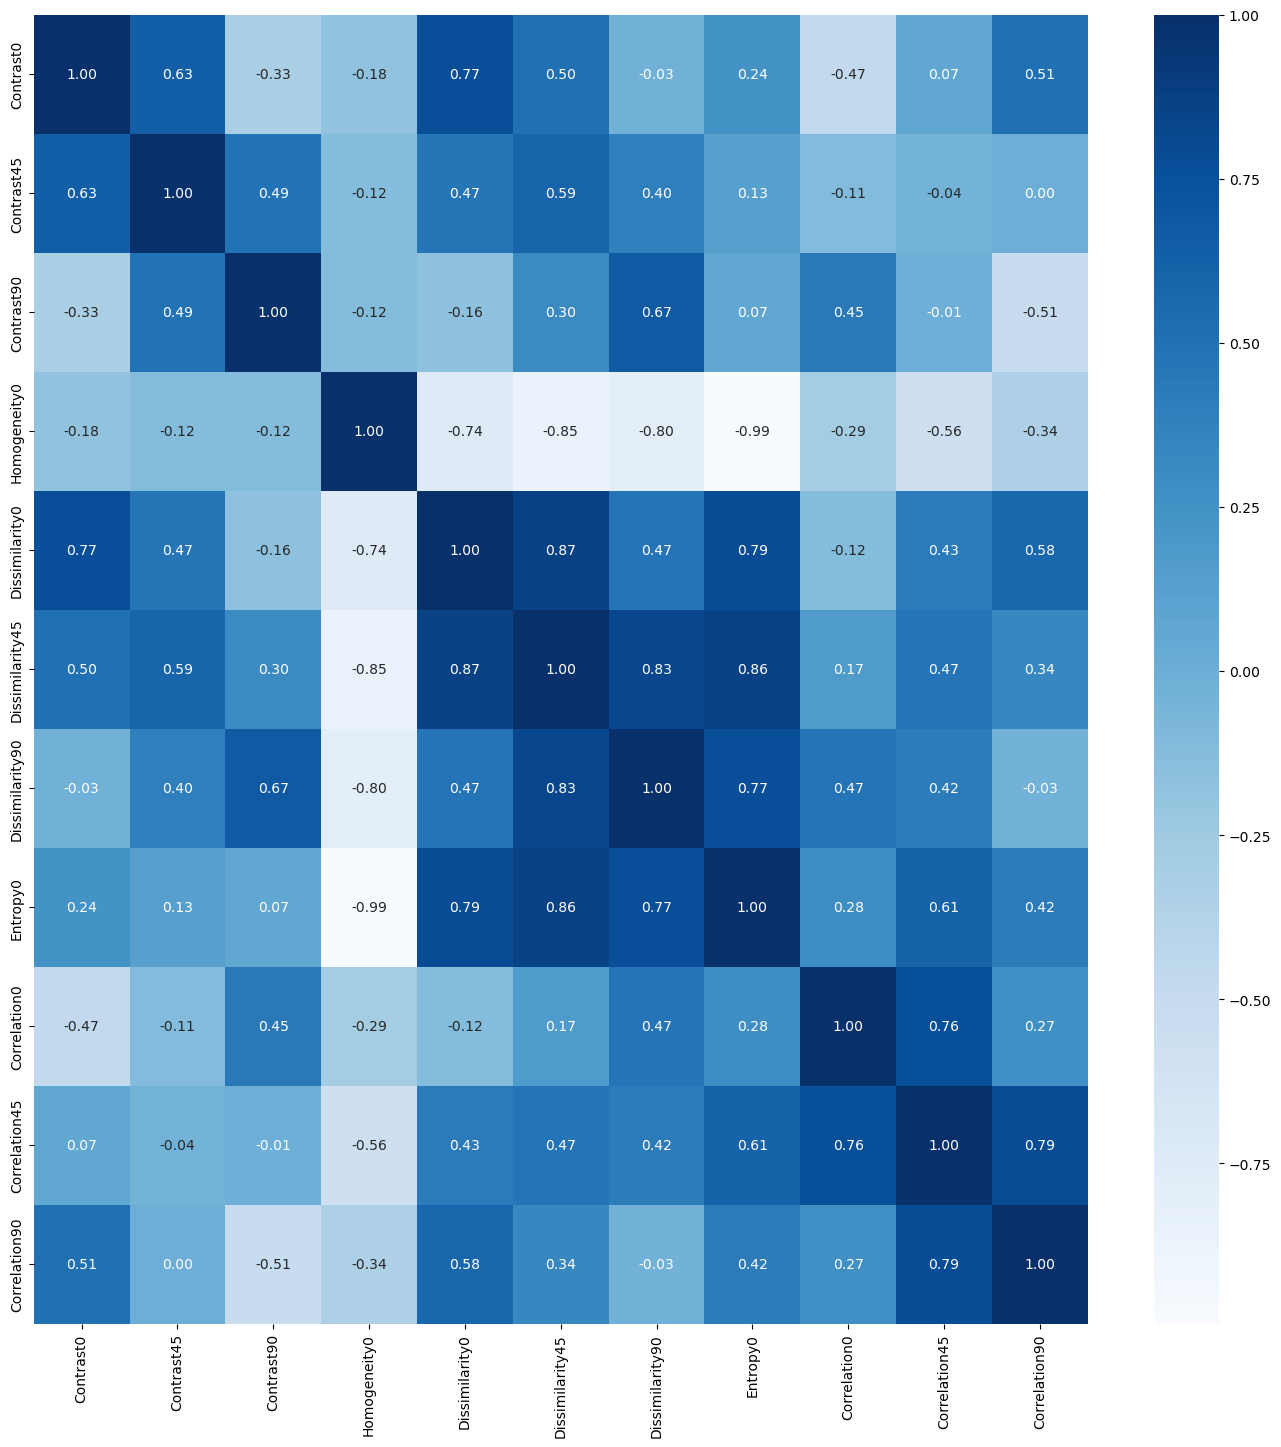

In [48]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [49]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 11)
(60, 11)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [50]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [51]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [52]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       nantu       0.96      0.97      0.97        78
      palapi       0.95      0.98      0.96        84
         uru       1.00      0.96      0.98        78

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240

[[76  2  0]
 [ 2 82  0]
 [ 1  2 75]]
Accuracy: 0.9708333333333333

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.64      0.73      0.68        22
      palapi       0.71      0.75      0.73        16
         uru       0.89      0.73      0.80        22

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.74        60
weighted avg       0.75      0.73      0.74        60

[[16  4  2]
 [ 4 12  0]
 [ 5  1 16]]
Accuracy: 0.7333333333333333


### Train SVM Classifier

In [53]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       nantu       0.58      0.47      0.52        78
      palapi       0.62      0.63      0.63        84
         uru       0.66      0.77      0.71        78

    accuracy                           0.62       240
   macro avg       0.62      0.62      0.62       240
weighted avg       0.62      0.62      0.62       240

[[37 23 18]
 [18 53 13]
 [ 9  9 60]]
Accuracy: 0.625

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.53      0.45      0.49        22
      palapi       0.59      0.62      0.61        16
         uru       0.58      0.64      0.61        22

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.57        60
weighted avg       0.56      0.57      0.56        60

[[10  6  6]
 [ 2 10  4]
 [ 7  1 14]]
Accuracy: 0.5666666666666667


### Train KNN Classifier

In [54]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       nantu       0.65      0.82      0.72        78
      palapi       0.77      0.64      0.70        84
         uru       0.82      0.74      0.78        78

    accuracy                           0.73       240
   macro avg       0.74      0.74      0.73       240
weighted avg       0.75      0.73      0.73       240

[[64  9  5]
 [22 54  8]
 [13  7 58]]
Accuracy: 0.7333333333333333

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.47      0.64      0.54        22
      palapi       0.59      0.62      0.61        16
         uru       0.69      0.41      0.51        22

    accuracy                           0.55        60
   macro avg       0.58      0.56      0.55        60
weighted avg       0.58      0.55      0.55        60

[[14  5  3]
 [ 5 10  1]
 [11  2  9]]
Accuracy: 0.55


## Evaluation With Confusion Matrix

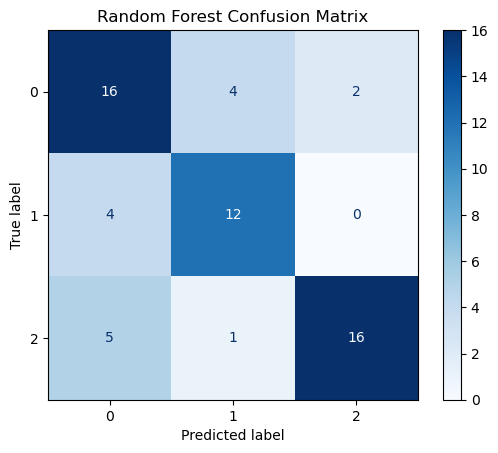

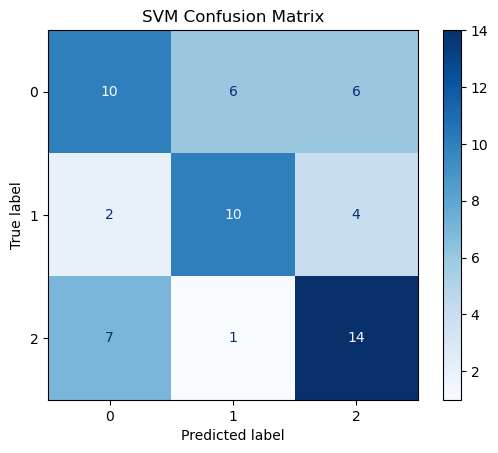

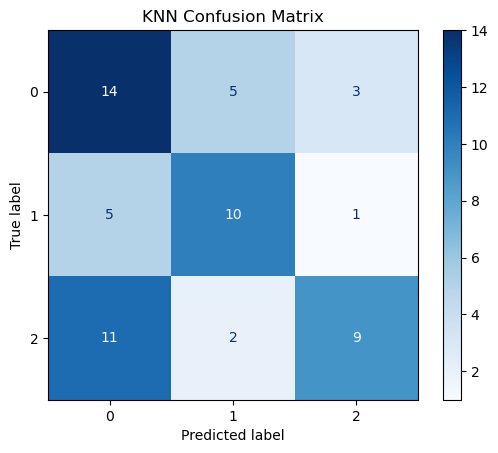

In [55]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")